In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Functions

In [2]:
def make_vote_df_from_proposal_id(proposal_id):
    url = 'https://hub.snapshot.org/graphql/'
    vote_query = create_vote_query(proposal_id)
    vote_response = requests.post(url, json={'query': vote_query})
    print(proposal_response.status_code,proposal_response.reason,proposal_id)
    vote_json = vote_response.json()
    vote_df = vote_json_to_df(vote_json)
    return vote_df
    
def create_vote_query(proposal_id):
    vote_query = '''
    query Votes {
      votes (
        first: 9999999
        skip: 0
        where: {
          proposal: "'''+ proposal_id + '''"
        }
        orderBy: "created",
        orderDirection: desc
      ) {
        id
        ipfs
        voter
        created
        space {
          id
        }
        proposal {
          id
        }
        choice
        metadata
        vp
        vp_by_strategy
        vp_state
      }
    }
    '''
    return vote_query
def vote_json_to_df(vote_json):
    row_as_series_list=[]
    for vote in vote_json['data']['votes']:
        id = vote['id']
        ipfs = vote['ipfs']
        voter = vote['voter']
        created = vote['created']
        space = vote['space']['id']
        proposal = vote['proposal']['id']
        choice = vote['choice']
        #metadata = vote['metadata']: {},
        vp = vote['vp']
        vp_by_strategy = tuple(vote['vp_by_strategy'])
        vp_state = vote['vp_state']
        row_as_series  = pd.Series(
            data=(
                id,
                ipfs,
                voter,
                created,
                space,
                proposal,
                choice,
                #metadata,
                vp,
                vp_by_strategy,
                vp_state,
                ),
            index=(
                'vote_id',
                'ipfs',
                'voter',
                'created',
                'space',
                'proposal',
                'choice',
                #'metadata',
                'vp',
                'vp_by_strategy',
                'vp_state',
            )
        )
        row_as_series_list.append(row_as_series)
    return_df = pd.DataFrame(row_as_series_list)
    return return_df


# Querying and Dumping the Data

In [3]:
proposal_query = '''
query Proposals {
  proposals (
    first: 10000000
    where: {
      space_in: ["index-coop.eth"],
      state: "closed"
    },
    orderBy: "created",
    orderDirection: desc
  ) {
    id
    title
    body
    choices
    start
    end
    snapshot
    state
    author
    scores
    scores_by_strategy
    scores_state
    scores_total
    scores_updated
    votes
    space {
      id
      name
    }
  }
}
'''
#print(proposal_query)

In [4]:
url = 'https://hub.snapshot.org/graphql/'
proposal_response = requests.post(url, json={'query': proposal_query})
print(proposal_response.status_code,proposal_response.reason)

200 OK


In [5]:
proposal_json = proposal_response.json()

In [6]:
#proposal_json

In [6]:
# Dump Proposal Dataframe
proposal_row_list = []
for proposal in proposal_json['data']['proposals']:
    id = proposal['id']
    title = proposal['title']
    body = proposal['body']
    choices = tuple(proposal['choices'])
    scores = tuple(proposal['scores'])
    scores_total = proposal['scores_total']
    votes = proposal['votes']
    
    proposal_row = pd.Series(data=[id,title,body,choices,scores,scores_total,votes],
                      index = ['proposal_id','title','body','choices','scores','scores_total','votes']
                     )
    proposal_row_list.append(proposal_row)

proposals_df = pd.DataFrame(proposal_row_list)



## Cleaning Proposal df

In [9]:
def make_proposal_category(title):
    '''
    Logic for parsing the title to categorize the proposal.
    '''
    if ('DG1' in title or 'Decision Gate 1' in title):
        category = 'DG1'
    elif ('DG2' in title or 'Decision Gate 2' in title): 
        category = 'DG2'
    elif ('IIP' in title): 
        category = 'IIP'
    else: 
        category = 'Metagovernance'
    return category
def make_proposal_result(row):
    '''
    Logic for checking if the proposal passed or not. 
    1 is FOR
    2 is AGAINST
    '''
    category = row['category']
    percentage_for = row['percentage_for']
    #print(category)
    #print(percentage_for)
    #print(type(percentage_for))
    if category == 'DG2':
        if percentage_for >.6:
            return 1 
        else:
            return 2
    else:
        if percentage_for >.5:
            return 1
        else:
            return 2
    

In [10]:
proposals_df['category'] = proposals_df['title'].apply(make_proposal_category) # Make category column
proposals_df = proposals_df[proposals_df['choices'].apply(len) == 2] # Remove multi-choice proposals
proposals_df = proposals_df[proposals_df['scores_total'] !=0] # Remove dummy proposals
proposals_df['percentage_for'] = proposals_df['scores'].map(lambda x: x[0])/proposals_df['scores_total']
proposals_df['result'] = proposals_df.apply(make_proposal_result,axis=1) # Make category column
proposals_df.to_json('proposals_df.json')

In [11]:
make_proposal_result(proposals_df.iloc[2])

1

### Double check that the choices are in the correct order

In [12]:
proposals_df['choices'].value_counts()

(FOR, AGAINST)                                                         93
(For, Against)                                                         85
(Approve, Reject)                                                       4
(FOR , AGAINST)                                                         2
(Yes, No)                                                               1
(Fund Balancer Grants DAO Wave 2, Do not fund)                          1
(Stop BAL for Gas, Continue BAL for Gas)                                1
(Approve, Deny)                                                         1
(Proceed with "Whale" Sponsorship, Do not proceed with sponsorship)     1
(Approve Grant, Deny Grant)                                             1
(Yes, I support this proposal, No, I am against this proposal)          1
(yes, I vote for this proposal, no, I vote against this proposal)       1
(Yes we would love a Telegram, Discord is enough)                       1
(FOR, AGAINST )                       

When we did this, we wanted the first choice to always be "yes"

In [12]:
#

In [13]:
# Dump Vote Dataframe
votes_df_list = []
for proposal in proposal_json['data']['proposals']:
    #print(proposal['state'],proposal['choices'])
    if proposal['state'] != 'closed':
        continue
    else:
        votes_for_proposals_df = make_vote_df_from_proposal_id(proposal['id'])
        votes_df_list.append(votes_for_proposals_df)
        
all_votes_df = pd.concat(votes_df_list,ignore_index=True)
all_votes_df['created'] = pd.to_datetime(all_votes_df['created'],unit='s') #Convert to datetime


200 OK Qmf9zQAiL1eJwDhy7SPXhNjSNhga3xnHrxLp373amCGnzV
200 OK 0x81ba2833504ea67c0d82e923a500afb54aa62ca74eeded97be6050d947a47e8e
200 OK QmaGZeBayJGQpFZWYSxrKndyf65ukyeTd9bFqjpDcbWMHG
200 OK QmPmuC4JZKy4kYqA7eBGHAgzpQUQNyGCb3wRZUudBKP3GN
200 OK QmTsi5WNdBknEBKEjXnzR5PRGRtv9FFLRYyoo5KzoJkvmB
200 OK 0xe3fff4b6a16f460fba6477b25fd531e7dd54cf8981323fc08508a99217234495
200 OK QmVxXii1pWq3b7Hpw24pmqebNb1svehcHWwJke3Q1SPEaR
200 OK QmdWAGRC1G5GnNff7jGcf2kjmNQ9v7KEYkNjTgDbQQAD4c
200 OK 0x940fea8c7965da18b12fc6a081478204d41cda975ca8acdf220a17b0b99193aa
200 OK 0x31a11f7f37c0319785cad3ab7353745731c3d33908b5ebd073c41276dd98264c
200 OK 0xc6735f6bba6dc6ba537077d08f4db0bf3695ec1086ddc8144d264a757e69061f
200 OK 0x40edf5d2828a0473626a8a7bfa22a8755fb847a95563e238665ba00ecfb279ca
200 OK 0xf617a54ce920d92e800bc8137367c97662446f5fc6e167f93049f840009ee1c4
200 OK QmSL8mUPtKp78YrsWmLw7t8X3jH348ZXjUeyEVyanJxV2A
200 OK QmSgaTqTbDaMDcoGdiDGy5HhYuLxZpraifsD4UxA1h8FdH
200 OK QmV1AkcZ2oJYDzPUGkdevE4NvBSAHoQwAkRV7ytFJyE

200 OK QmWCsf6bwsg2Xt5GbGM5DTjUDD4JWce1irVxEhmza8bj8C
200 OK QmbyA286dMzYRQDuYdMghCAUKXQH3hZWp4FQ5m8kYoL5Ki
200 OK QmPDTLqmThdHqpG8TSXBmkHEYYZetc4dbNh3CCHRUfphnn
200 OK QmSYRYTvuy1XuSP5dgwFoUM21uJQgSfRXuULwv4GvKuQmS
200 OK QmPokVV38XZz1dip8p4aitHPQLUdYnhKDKpyADNMn7GVLt
200 OK QmfGRkXA5gj2ske8Ci45wZnA9BRQg38iQ9vkpegABi9EbW
200 OK QmNeM26WeUs43RvbF71rbqEutgSZQTUDRpUWy6tsJ27pha
200 OK QmTbkoreSsv4wwybA3EjjhKaCMCeNYeCFjCr93MTd7bERJ
200 OK QmeBhJUWTJoPVk9hqaLftcXNKJkjs63bs4VRBvViX6WniX
200 OK QmVRZZXE4NFb8mVrYp4Hz5iHHf9AhD8enE2jEtJwFkKovN
200 OK Qmc2DPHoKnyYxRjQfwbpbBngt5xHZrLBgkywGqZm7hHnEU
200 OK QmYBG5zerdSkC9TGwguy5biCS5h2cg49PQCHCukJqHmfE1
200 OK QmRyCX1DYp6s7aGXGMyPC45FX917vXYkZgksXg9fjo8GrP
200 OK QmUPP126SvEUidcT7noCcLa4LSc3e7t3VkWLiD8EJ3vjUt
200 OK QmaE8dWs4pgMcG8Fu4oxq8aGyveDxv6YVLJHiRVpiSnsfK
200 OK Qmc5naesmRQ36yYVc2U2jJPvykLqVg4BWfBZWbjC9mAjM7
200 OK QmbkocKzcWsfysBSUKWhLYDoMgNhWudxXH58ntwN2XoqN3
200 OK QmWHAmKhyLDPU1QmkGgfSGHn29247kNLqEmTFF5xCeEbvp
200 OK QmcQXqTYJVWv8v2eMXvmB

NameError: name 'remove_zero_vp_proposals' is not defined

## Cleaning Vote Dataframe

In [14]:
def remove_zero_vp_proposals(all_votes_df):
    vp_sum_df = all_votes_df.groupby('proposal')['vp'].sum() 
    zero_vp_proposals = vp_sum_df[vp_sum_df==0].index
    all_votes_df = all_votes_df[~all_votes_df['proposal'].isin(zero_vp_proposals)]
    return all_votes_df

In [15]:
all_votes_df = remove_zero_vp_proposals(all_votes_df) 
all_votes_df.to_json('all_votes_df.json')

# Analysis

###  What percentage of proposals are unanimous?


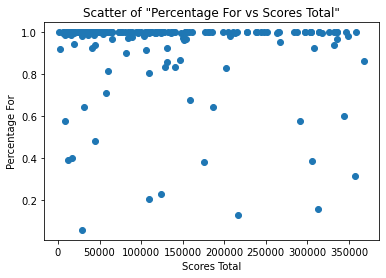

In [16]:
# What percentage of proposals are unanimous?
proposals_df['percentage_for'] = proposals_df['scores'].map(lambda x: x[0])/proposals_df['scores_total']
plt.scatter(proposals_df['scores_total'],proposals_df['percentage_for'])
plt.xlabel('Scores Total')
plt.ylabel('Percentage For')
plt.title('Scatter of "Percentage For vs Scores Total"')
plt.show()

# King Maker / Deciding Vote

In [17]:
def winning_threshold(choice,category):
    if category == 'DG2':
        if choice == 1:
            return .6
        else:
            return .4
    else:
        return .5
    
def is_deciding_vote(row):
    '''
    Assuming that a vote is ALREADY on the winning side,
    A vote is a considered a deciding vote if the following statement holds:
    'If the vote had switched sides, then it would have still been on the winning side.'
    '''
    vp = row['vp']
    choice = row['choice']
    category = row['category']
    scores_total = row['scores_total']
    coalition_vp = row['coalition_vp']
    #old_choice = choice
    #old_my_team_score= coalition_vp
    #old_enemy_team_score = scores_total-coalition_vp

    new_choice = (choice) % 2 + 1 # 1 goes to 2, 2 goes to 1
    new_coalition_vp = scores_total-(coalition_vp-vp)


    new_percentage = new_coalition_vp/scores_total

    new_wins = new_percentage > winning_threshold(new_choice,category)

    return new_wins

In [18]:
#Merge
merged_df = pd.merge(all_votes_df,proposals_df,left_on='proposal',right_on='proposal_id',how='inner')

In [19]:
#Create columns
merged_df['coalition_vp'] = merged_df.apply(lambda row: row.scores[row.choice-1],axis=1)
merged_df['coalition_contribution'] = merged_df['vp']/merged_df['coalition_vp']
merged_df['is_winning_coalition'] = merged_df['choice']==merged_df['result']

In [20]:
#Filter and create deciding_vote column
winning_coalition_df = merged_df[merged_df['is_winning_coalition']]
winning_coalition_df['is_deciding_vote'] = winning_coalition_df.apply(is_deciding_vote,axis=1)


/var/folders/gk/ws1y65fn3l3_f44tyj7ms26h0000gn/T/ipykernel_73521/1840099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_coalition_df['is_deciding_vote'] = winning_coalition_df.apply(is_deciding_vote,axis=1)


In [21]:
#Pivot
deciding_vote_df = winning_coalition_df.sort_values(by='coalition_contribution',ascending=False).groupby(['voter','is_deciding_vote']).size()\
                       .reset_index(name='counts')\
                       .pivot_table(index='voter',columns='is_deciding_vote',values='counts',fill_value=0)\
                       .sort_values(by=True,ascending=False)

In [22]:
deciding_vote_df

is_deciding_vote,False,True
voter,,
0x8627be8D8b6D250c87f802D0c48C26FA807A0857,0,26
0x042a135bd342910ad7F67bBda74e3fd4125D1272,77,11
0x4a3e950c35c6d9c2d8f5F0a6CC03aF9942134840,12,8
0x365047213ABe97401e8Bfa2c48D12d2731601F98,0,6
0xe1B6e4C28127C4704838A0a2d6c6F7c344944B22,8,6
...,...,...
0x53f0a8420474a1E05383096B9F6560c115cDD7fd,1,0
0x54073942343E364e4e220075592B39E9512d5629,1,0
0x543536BC5B66471aF8eE0d5596352A5814f71d39,1,0
